In [ ]:
import math
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm.notebook as tqdm # progress bars

from itertools import product

from scipy.sparse import csr_matrix

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers

In [ ]:
# def safe_train_test_split(users, items, test_size=0.25, random_state=0):
    '''
    Performs a train test split on interactions, guaranteeing that every user 
    will be represented in both the train and the test split (assuming each user appears twice).
    Note that sklearn's train_test_split function, even when stratified by user does not guarantee this,
    unless the test_size is such that every user should be in both splits (0.5 if only 2 reviews/user)
    
    users is a list of user_ids
    items is a list of items_ids
    test_size is the approximate proportion of samples to be considered "test samples"
    
    The indices of users and items should correlate to represent all positive interactions
    '''
    user_train = []
    user_test = []
    
    item_train = []
    item_test = []
    
    random.seed(random_state)
    
    for user_id in tqdm.tqdm(users.unique()):
        examples = list(users[users.values == user_id].index)
        random.shuffle(examples)
        
        # Not enough samples to perform proper split: pull one into test, then throw the rest in train
        if len(examples) * test_size < 1:
            user_test.append(user_id)
            item_test.append(items[examples[0]])
            
            for i in range(1, len(examples)):
                user_train.append(user_id)
                item_train.append(items[examples[i]])
        # Enough to perform proper split: throw into train and test according to test_size
        else:
            test_samples = int(len(examples) * test_size)
            
            for i in range(0, test_samples):
                user_test.append(user_id)
                item_test.append(items[examples[i]])
                
            for j in range(test_samples, len(examples)):
                user_train.append(user_id)
                item_train.append(items[examples[j]])
            
    return user_train, user_test, item_train, item_test

In [3]:
def make_recipe_ingr_xref(recipes):
    '''
    recipes is the pandas dataframe for preprceossed recipes. The ingredient_ids column should store lists of integers
    
    Returns new pandas dataframe, a cross-reference table for all recipes and ingredients
    '''
    
    recipe_ids = []
    ingr_ids = []
    
    for row in tqdm.tqdm(recipes['ingredient_ids'].index):
        for ingr_id in recipes['ingredient_ids'][row]:
            recipe_ids.append(recipes.loc[row, 'i'])
            ingr_ids.append(ingr_id)
            
    return pd.DataFrame.from_dict({'i': recipe_ids, 'ingr': ingr_ids})

In [4]:
def get_positive_interactions(interactions, user_id):
    '''
    interactions is a pandas dataframe describing all known positive interactions, for filtering purposes
    user_id is an integer specifying the user for which to pull the positive interactions
    
    returns a list of recipe_ids, specifying the recipes the given user has interacted with
    '''
    
    return interactions[interactions['u'] == user_id]['i'].values

In [5]:
def get_reccomendations(predictions, k, filtered_recipe_ids=[], filter_val=-100):
    '''
    General purpose function for pulling reccomendations based on a value for each recipe
    
    predictions is a numpy array of length num_recipes, that assigns a value to each recipe
    k is an integer, the number of reccomendations to generate
    filtered_recipe_ids is a list of recipe_ids, specifying which recipes should not be included in the reccomendations
    filter_val is the value that replaces filtered recipe_ids for filtering purposes
    
    Returns recipe_ids, a list of the top k reccomended recipes, with index 0 being the most reccomended
    '''
    
    # Replace all recipes to be filtered out with the filter value, which should be a lower value
    predictions[filtered_recipe_ids] = filter_val
    
    # Get the top k reccomendations for the user (NOTE: these are not in order)
    unsorted_recs = np.argpartition(predictions, -k)[-k:]
    
    # Sort the reccomendations by their predictions values, in descending order
    sorted_recs = sorted(unsorted_recs, key=lambda rec: predictions[rec], reverse=True)

    return sorted_recs

In [6]:
def collab_filter_reccomendations(item_embedding, user_embedding, user_id, k, interactions=None, filter_recs=False):
    '''
    item embedding is of shape (items, features) describing the features for each item
    user_embedding is of shape (users, features) describing the features for each user
    user_id is an integer specifying the user to get reccomendations for
    k is an integer specifying the number of reccomendations to pull
    interactions is a pandas dataframe describing all known positive interactions, for filtering purposes
        Note: interactions is only required if filter_recs is true
    filter_recs is a boolean, specifying whether or not to filter known positive interactions specified in interactions
    
    Returns a list of recipe_ids similar to the general-purpose get_reccomendations function
    '''
    
    predictions = item_embedding @ user_embedding[user_id, :]
    
    filtered_recipe_ids = get_positive_interactions(interactions, user_id) if filter_recs else []

    return get_reccomendations(predictions, k, filtered_recipe_ids)

In [7]:
def collab_filter_train_test_matrix(item_embedding, user_embedding, k, interactions):
    '''
    parameters are defined as for collab_filter_reccomendations
    
    Returns a tuple (train_rec_matrix, test_rec_matrix) where both are matrices of size (num_users, k) providing
        the top k reccomendations for each user (most reccomended at index 0). train_rec_matrix does not filter known
        positive interactions, while test_rec_matrix does filter known positive interactions
    '''
    
    train_rec_matrix = []
    test_rec_matrix = []
    
    for user_id in tqdm.tqdm(range(user_embedding.shape[0])):
        predictions = item_embedding @ user_embedding[user_id, :]
        filtered_recipe_ids = get_positive_interactions(interactions, user_id)
        
        train_recs = get_reccomendations(predictions, k)
        test_recs = get_reccomendations(predictions, k, filtered_recipe_ids)

        train_rec_matrix.append(train_recs)
        test_rec_matrix.append(test_recs)
    return np.array(train_rec_matrix), np.array(test_rec_matrix)

In [8]:
def similar_recipes(embeddings, recipe_id, k):
    '''
    Embeddings is a matrix of shape (num_recipes, num_feature)
    recipe_id is an integer, the recipe to find similar recipes to
    
    Note that embeddings could be tf-idf embeddings to produce content-based reccomendations ("similar recipes")
        OR embeddings could be item_embeddings generated from collaborative filtering ("customers who liked this recipe also liked")
    
    Returns a list of recipe_ids, the most similar recipes to the given recipe
    '''
    
    # Values for each recipe based on similarity to given recipe
    similarities = cosine_similar_predictions(embeddings, embeddings[recipe_id])
    
    # Get reccomendations, filtering out the queries recipe
    return get_reccomendations(similarities, k, filtered_recipe_ids=[recipe_id])

In [9]:
def mean_profile_reccomendations(embeddings, user_id, k, interactions, filter_recs=False):
    '''
    Parameters defined as above
    
    Returns a list of recipe_ids, reccomended based on the mean embedding of all recipes the user has interacted with
    '''
    
    interacted_ids = get_positive_interactions(interactions, user_id)
    
    interacted_embeddings = embeddings[interacted_ids]

    average_embedding = np.mean(interacted_embeddings, axis=0)

    similarities = cosine_similar_predictions(embeddings, average_embedding)

    return get_reccomendations(similarities, k, filtered_recipe_ids=interacted_ids if filter_recs else [])

In [10]:
def mean_profile_train_test_matrix(embeddings, k, interactions):
    '''
    Produces a matrix of size (num_users, k) providing the top k reccomendations for each user
    
    This takes like 12 minutes to run with tf_idf embeddings, I think because of the ~8000 features
    This takes 6 minutes for collab_filter embeddings, with only 8 features. Probably longer b/c it normalizes similarities
    '''
    
    train_rec_matrix = []
    test_rec_matrix = []
    
    for user_id in tqdm.tqdm(range(max(interactions['u']) + 1)):
    #for user_id in tqdm.tqdm(range(10)):
        interacted_ids = get_positive_interactions(interactions, user_id)
        interacted_embeddings = embeddings[interacted_ids]
        average_embedding = np.mean(interacted_embeddings, axis=0)
        similarities = cosine_similar_predictions(embeddings, average_embedding)

        train_recs = get_reccomendations(similarities, k)
        test_recs = get_reccomendations(similarities, k, filtered_recipe_ids=interacted_ids)

        train_rec_matrix.append(train_recs)
        test_rec_matrix.append(test_recs)
        
    return np.array(train_rec_matrix), np.array(test_rec_matrix)

In [11]:
def random_rec_matrix(num_users, num_recipes, k):
    '''
    Function to create a dummy reccomendation matrix, as a baseline for other models
    '''
    
    rec_matrix = []
    
    for user_id in tqdm.tqdm(range(num_users)):
        rec_matrix.append([random.randint(0, num_recipes - 1) for i in range(k)])
        
    return np.array(rec_matrix)

In [12]:
def get_tf_idf_embeddings(recipe_ingr_xref):
    '''
    recipe_ingr_xref is a pandas Dataframe, like the one returned from makr_recipe_ingr_xref
    
    returns a sparse matrix of tf-idf embeddings for each recipe
    ''' 
    
    # Create the document frequency matrix
    ingr_freq = csr_matrix((np.ones(len(recipe_ingr_xref)), (recipe_ingr_xref['i'], recipe_ingr_xref['ingr'])))
    
    # Generate the tf-idf embeddings from the document frequency matrix
    tf = TfidfTransformer()
    tf_idf_embeddings = tf.fit_transform(ingr_freq) 
    
    return tf_idf_embeddings

In [13]:
def cosine_similar_predictions(embeddings, query):
    '''
    embeddings is a matrix of shape (num_recipes, num_features)
    query is a list of length num_features
    '''
    
    return cosine_similarity(embeddings, query.reshape(1, -1)).squeeze()

In [2]:
raw_recipes = pd.read_csv("data/RAW_recipes.csv")
raw_interactions = pd.read_csv("data/RAW_interactions.csv")
pp_recipes = pd.read_csv("data/PP_recipes.csv")
pp_users = pd.read_csv("data/PP_users.csv")
ingr_map = pd.read_pickle("data/ingr_map.pkl")
pp_recipes['ingredient_ids'] = pp_recipes['ingredient_ids'].map(lambda str: [int(ingr_id) for ingr_id in str[1:-1].split(', ')])


In [8]:
ingr_map.nunique()

raw_ingr     11659
raw_words       12
processed     9035
len_proc        55
replaced      8023
count          840
id            8023
dtype: int64

In [16]:
# Create a cross-reference tables for all recipes and ingredients
recipe_ingr_xref = make_recipe_ingr_xref(pp_recipes)
recipe_ingr_xref


  0%|          | 0/178265 [00:00<?, ?it/s]

,i,ingr
0,23,389
1,23,7655
2,23,6270
3,23,1527
4,23,3406
...,...,...
1605467,137160,335
1605468,137160,1563
1605469,137160,1511
1605470,137160,3248


In [17]:
# Get the tf-idf embeddings
tf_idf_embeddings = get_tf_idf_embeddings(recipe_ingr_xref)
tf_idf_embeddings

<178265x8023 sparse matrix of type '<class 'numpy.float64'>'
	with 1602903 stored elements in Compressed Sparse Row format>

In [18]:
# Merge preprocessed and raw recipe tables
full_recipes = pp_recipes.merge(raw_recipes, left_on='id', right_on='id')

In [21]:
recipe_id = 3
k = 10

content_recs = similar_recipes(tf_idf_embeddings, recipe_id, k)
#collab_recs = similar_recipes(model.item_factors, recipe_id, k)

print(f'If you liked {full_recipes[full_recipes["i"] == recipe_id].iloc[0]["name"]}, you might also like:')
for i, rec in enumerate(content_recs):
    print(full_recipes[full_recipes['i'] == rec].iloc[0]['name'])
    
""" print()    

print(f'Customers who liked {full_recipes[full_recipes["i"] == recipe_id].iloc[0]["name"]} also liked:')
for i, rec in enumerate(collab_recs):
    print(full_recipes[full_recipes['i'] == rec].iloc[0]['name']) """

If you liked kfc honey bbq strips, you might also like:
honey barbecue chicken strips
barbecued sausage pieces  crock pot
the sweetest fried chicken tenders
low fat fried chicken strips
kentucky fried chicken honey bbq chicken strips
sesame sauced chicken thighs
parmesan fried chicken
easy and saucy crock pot pork chops   healthier version
barbecue beef pouch potatoes
chicken prosciutto pieces


' print()    \n\nprint(f\'Customers who liked {full_recipes[full_recipes["i"] == recipe_id].iloc[0]["name"]} also liked:\')\nfor i, rec in enumerate(collab_recs):\n    print(full_recipes[full_recipes[\'i\'] == rec].iloc[0][\'name\']) '

# memory based collaborative (and why it doesn't work)

In [108]:
raw_interactions.head()
ratings = raw_interactions[["user_id", "recipe_id", "rating"]]
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1132367 non-null  int64
 1   recipe_id  1132367 non-null  int64
 2   rating     1132367 non-null  int64
dtypes: int64(3)
memory usage: 25.9 MB


In [109]:
dishes = raw_recipes[["id", "name"]]
dishes.rename(columns={'id':'recipe_id'}, inplace = True)
dishes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   recipe_id  231637 non-null  int64 
 1   name       231636 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


C:\Users\dinie\AppData\Local\Temp\ipykernel_960\1865938042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dishes.rename(columns={'id':'recipe_id'}, inplace = True)


In [36]:
df = pd.merge(ratings, dishes, on='recipe_id', how='inner')

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   rating     1132367 non-null  int64 
 3   name       1132366 non-null  object
dtypes: int64(3), object(1)
memory usage: 43.2+ MB


In [87]:
agg_ratings = df.groupby('name').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>1000]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 21337 to 227814
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8 non-null      object 
 1   mean_rating        8 non-null      float64
 2   number_of_ratings  8 non-null      int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 256.0+ bytes


In [88]:
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head(10)


,name,mean_rating,number_of_ratings
21337,best banana bread,4.186493,1614
212437,to die for crock pot roast,4.288570,1601
64607,crock pot chicken with black beans cream cheese,4.220393,1579
61387,creamy cajun chicken pasta,4.541436,1448
21559,best ever banana cake with cream cheese frosting,4.329047,1322
227814,yes virginia there is a great meatloaf,4.213793,1305
114177,jo mama s world famous spaghetti,4.423015,1234
224158,whatever floats your boat brownies,4.525410,1220


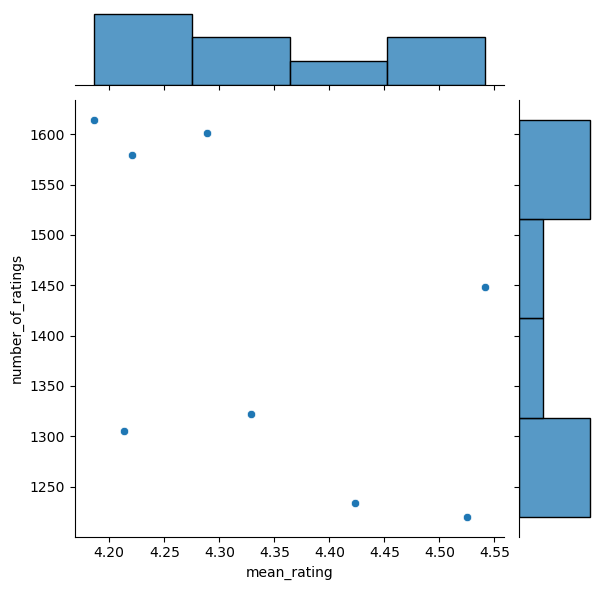

In [89]:
import seaborn as sns
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [90]:
df_GT100 = pd.merge(df, agg_ratings_GT100[['name']], on='name', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11323 entries, 0 to 11322
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    11323 non-null  int64 
 1   recipe_id  11323 non-null  int64 
 2   rating     11323 non-null  int64 
 3   name       11323 non-null  object
dtypes: int64(3), object(1)
memory usage: 442.3+ KB


In [91]:
# Number of users
print('The ratings dataset has', df_GT100['user_id'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['recipe_id'].nunique(), 'unique recipes')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 9619 unique users
The ratings dataset has 9 unique recipes
The ratings dataset has 6 unique ratings
The unique ratings are [0, 1, 2, 3, 4, 5]


In [92]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='user_id', columns='name', values='rating')
matrix.head()

name,best banana bread,best ever banana cake with cream cheese frosting,creamy cajun chicken pasta,crock pot chicken with black beans cream cheese,jo mama s world famous spaghetti,to die for crock pot roast,whatever floats your boat brownies,yes virginia there is a great meatloaf
user_id,,,,,,,,
1535,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN
1891,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
1962,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
2312,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2957,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [93]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

name,best banana bread,best ever banana cake with cream cheese frosting,creamy cajun chicken pasta,crock pot chicken with black beans cream cheese,jo mama s world famous spaghetti,to die for crock pot roast,whatever floats your boat brownies,yes virginia there is a great meatloaf
user_id,,,,,,,,
1535,NaN,NaN,0.5,NaN,NaN,-0.5,NaN,NaN
1891,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1962,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2312,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2957,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [99]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

user_id,1535,1891,1962,2312,2957,4439,4740,5815,5946,6258,...,2002338645,2002339556,2002347738,2002348649,2002352332,2002363202,2002364395,2002365857,2002366558,2002371445
user_id,,,,,,,,,,,,,,,,,,,,,
1535,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
picked_userid = 1535

# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity.head()

user_id,1535,1891,1962,2312,2957,4439,4740,5815,5946,6258,...,2002338645,2002339556,2002347738,2002348649,2002352332,2002363202,2002364395,2002365857,2002366558,2002371445
user_id,,,,,,,,,,,,,,,,,,,,,
1891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4439,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
n = 30

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1535 are user_id
43083         1.0
50969         1.0
456858        1.0
457489        1.0
457829        1.0
552052        1.0
560694        1.0
591314        1.0
677474        1.0
716215        1.0
774409        1.0
1122407       1.0
1133190       1.0
1365025       1.0
1581225       1.0
2687969       1.0
1800091321    1.0
426903        1.0
353131        1.0
340776        1.0
125640        1.0
61525         1.0
68960         1.0
69138         1.0
72017         1.0
73469         1.0
123428        1.0
126618        1.0
297380        1.0
135377        1.0
Name: 1535, dtype: float64


In [104]:
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

name,creamy cajun chicken pasta,to die for crock pot roast
user_id,,
1535,0.5,-0.5


In [105]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

name,best banana bread,best ever banana cake with cream cheese frosting,creamy cajun chicken pasta,crock pot chicken with black beans cream cheese,jo mama s world famous spaghetti,to die for crock pot roast,whatever floats your boat brownies,yes virginia there is a great meatloaf
user_id,,,,,,,,
43083,NaN,NaN,0.666667,NaN,NaN,-1.333333,0.666667,NaN
50969,NaN,NaN,0.750000,NaN,NaN,-0.250000,-0.250000,-0.250000
61525,NaN,NaN,2.500000,NaN,NaN,-2.500000,NaN,NaN
68960,NaN,NaN,0.500000,NaN,NaN,-0.500000,NaN,NaN
69138,NaN,NaN,0.500000,NaN,NaN,-0.500000,NaN,NaN
72017,NaN,NaN,2.500000,NaN,NaN,-2.500000,NaN,NaN
73469,NaN,NaN,1.000000,NaN,NaN,-1.000000,NaN,NaN
123428,NaN,NaN,0.500000,NaN,NaN,-0.500000,NaN,NaN
125640,NaN,NaN,1.200000,1.200000,0.200000,-0.800000,NaN,-1.800000


In [106]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_movies

name,best banana bread,best ever banana cake with cream cheese frosting,crock pot chicken with black beans cream cheese,jo mama s world famous spaghetti,whatever floats your boat brownies,yes virginia there is a great meatloaf
user_id,,,,,,
43083,NaN,NaN,NaN,NaN,0.666667,NaN
50969,NaN,NaN,NaN,NaN,-0.250000,-0.250000
61525,NaN,NaN,NaN,NaN,NaN,NaN
68960,NaN,NaN,NaN,NaN,NaN,NaN
69138,NaN,NaN,NaN,NaN,NaN,NaN
72017,NaN,NaN,NaN,NaN,NaN,NaN
73469,NaN,NaN,NaN,NaN,NaN,NaN
123428,NaN,NaN,NaN,NaN,NaN,NaN
125640,NaN,NaN,1.200000,0.200000,NaN,-1.800000


In [107]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)

,movie,movie_score
0,best banana bread,0.625000
1,best ever banana cake with cream cheese frosting,0.532143
4,whatever floats your boat brownies,0.480820
2,crock pot chicken with black beans cream cheese,0.238839
3,jo mama s world famous spaghetti,0.094388
5,yes virginia there is a great meatloaf,-0.455087


#kNN 

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
userid, recipe_id, title, rating

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   rating     1132367 non-null  int64 
 3   name       1132366 non-null  object
dtypes: int64(3), object(1)
memory usage: 43.2+ MB


In [117]:
refined_dataset = df.groupby(by=['user_id','name'], as_index=False).agg({"rating":"mean"})
refined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132249 entries, 0 to 1132248
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   user_id  1132249 non-null  int64  
 1   name     1132249 non-null  object 
 2   rating   1132249 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 25.9+ MB


In [119]:
num_users = len(refined_dataset['user_id'].value_counts())
num_items = len(refined_dataset['name'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of recipes in the dataset: {}'.format(num_items))

Unique number of users in the dataset: 226569
Unique number of recipes in the dataset: 230185


In [16]:
ingr_df = ingr_map.copy(deep=True)
ingr_df = ingr_df.rename({"id":"ingr_id","replaced":"ingr_name"}, axis="columns")
ingr_df = ingr_df[["ingr_id", "ingr_name"]]
ingr_df = ingr_df.drop_duplicates(ignore_index=True)
ingr_df.head(10)

,ingr_id,ingr_name
0,4308,lettuce
1,2744,french vanilla pudding and pie filling mix
2,6843,stove top stuffing mix
3,1910,cream cheese
4,1168,cheddar
5,5811,radicchio
6,5205,pasta sauce
7,7233,tomato sauce
8,6482,shredded three cheese
9,4836,mozzarella


In [120]:
rating_count_df = pd.DataFrame(refined_dataset.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
0.0,60841
1.0,12817
1.5,2
2.0,14121
2.5,5
3.0,40850
4.0,187327
4.5,30
5.0,816256


In [121]:
total_count = num_items * num_users
zero_count = total_count-refined_dataset.shape[0]
zero_count
     

52151653016

In [125]:
rating_count_df

,count
rating,
0.0,60841
1.0,12817
1.5,2
2.0,14121
2.5,5
3.0,40850
4.0,187327
4.5,30
5.0,816256


Text(0, 0.5, 'number of ratings')

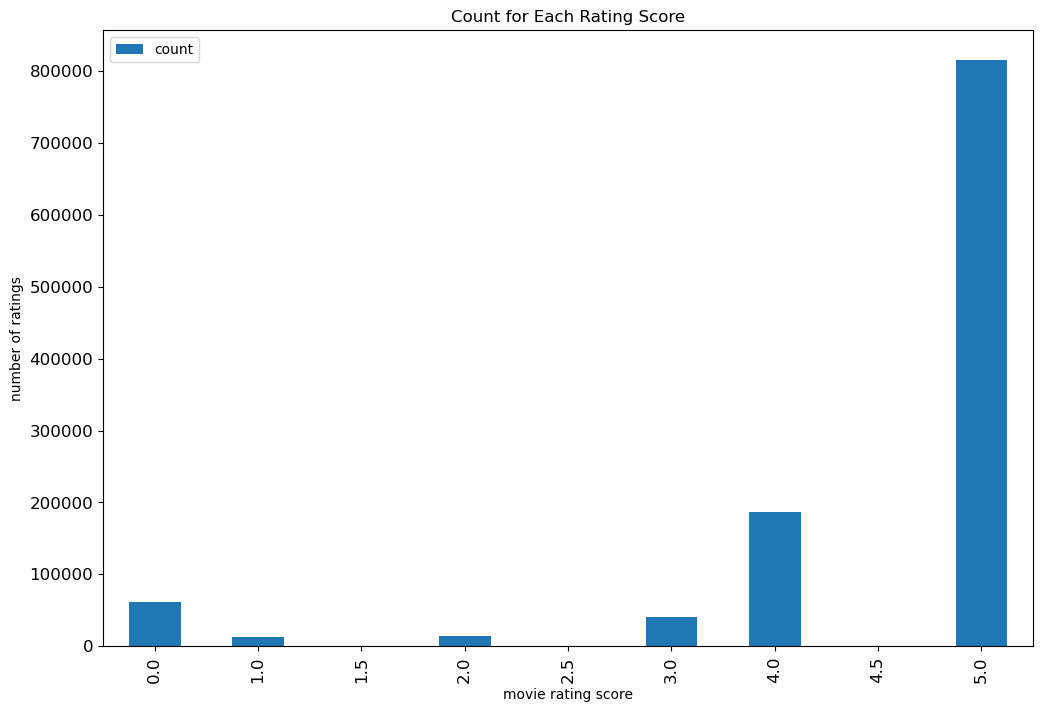

In [123]:

ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [127]:
movies_count_df = pd.DataFrame(refined_dataset.groupby('name').size(), columns=['count'])
movies_count_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230185 entries, 0 carb   0 cal gummy worms to zydeco ya ya deviled eggs
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   count   230185 non-null  int64
dtypes: int64(1)
memory usage: 3.5+ MB


Text(0, 0.5, 'number of ratings')

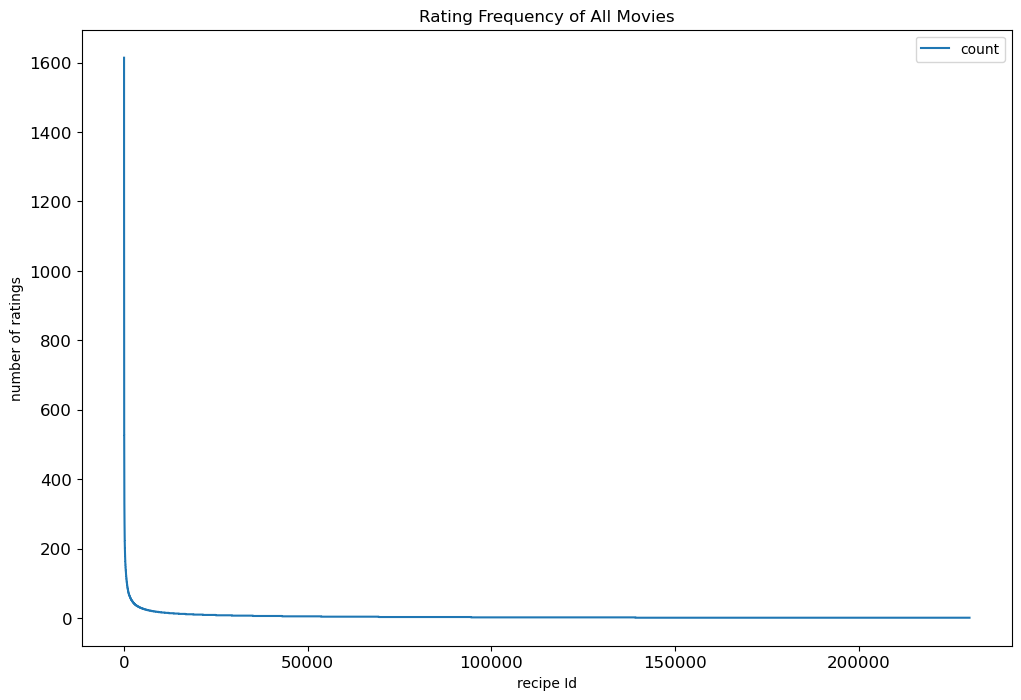

In [129]:
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("recipe Id")
ax.set_ylabel("number of ratings")
     

In [130]:
user_to_movie_df = refined_dataset.pivot(
    index='user_id',
     columns='name',
      values='rating').fillna(0)

user_to_movie_df.head()

c:\Users\dinie\anaconda3\lib\site-packages\pandas\core\reshape\reshape.py:130: RuntimeWarning: overflow encountered in long_scalars
  num_cells = num_rows * num_columns


IndexError: index 613179705 is out of bounds for axis 0 with size 613177713

In [131]:
user_to_movie_df = refined_dataset.pivot_table(index='user_id', columns='name', values='rating')
user_to_movie_df.head()

c:\Users\dinie\anaconda3\lib\site-packages\pandas\core\reshape\reshape.py:130: RuntimeWarning: overflow encountered in long_scalars
  num_cells = num_rows * num_columns


IndexError: index 613179705 is out of bounds for axis 0 with size 613177713

In [132]:
user_to_movie_sparse_df = csr_matrix(matrix.values)
user_to_movie_sparse_df

<9619x8 sparse matrix of type '<class 'numpy.float64'>'
	with 76059 stored elements in Compressed Sparse Row format>

In [ ]:
from pprint import pprint

def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):
  
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
  def get_similar_users(user, n = 5):
    
    knn_input = np.asarray([user_to_movie_df.values[user-1]])
    
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
    
    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")

    for i in range(1,len(distances[0])):
      print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    print("")
    return indices.flatten()[1:] + 1, distances.flatten()[1:]

def filtered_movie_recommendations(n = 10):
  
    first_zero_index = np.where(mean_rating_list == 0)[0][-1]
    sortd_index = np.argsort(mean_rating_list)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])
    filtered_movie_list = list(movies_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
      if i not in movies_watched:
        count+=1
        final_movie_list.append(i)
      if count == n:
        break
    if count == 0:
      print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
      pprint(final_movie_list)

  similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
  weightage_list = distance_list/np.sum(distance_list)
  mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
  movies_list = user_to_movie_df.columns
  weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
  new_rating_matrix = weightage_list*mov_rtngs_sim_users
  mean_rating_list = new_rating_matrix.sum(axis =0)
  print("")
  print("Movies recommended based on similar users are: ")
  print("")
  filtered_movie_recommendations(n_movies)

In [ ]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)
# recommender_system(300, 15,15)

In [133]:
refined_dataset

,user_id,name,rating
0,1533,apricot mousse,5.0
1,1533,bacon and cheese egg appetizers,5.0
2,1533,barley potato soup,4.0
3,1533,basic beer batter,5.0
4,1533,basil garlic butter,5.0
...,...,...,...
1132244,2002371755,pumpkin bread less sugar and less oil still...,5.0
1132245,2002371792,stupid simple sugar cookies,4.0
1132246,2002371843,black bean chocolate cake,5.0
1132247,2002372464,maple pecan refrigerator cookies,4.0


In [145]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
     

# from keras.models import Model
# from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
# from keras.optimizers import Adam
# from keras.regularizers import l2
# from keras.layers import Concatenate, Dense, Dropout
# from keras.layers import Add, Activation, Lambda

import tensorflow as tf
#import keras
from pprint import pprint

ModuleNotFoundError: No module named 'tensorflow'

In [139]:

user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user_id'].values)
n_users = refined_dataset['user'].nunique()

In [140]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['name'].values)
n_movies = refined_dataset['movie'].nunique()
     

In [141]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(226569, 230185, 0.0, 5.0)

In [142]:
refined_dataset.head()

,user_id,name,rating,user,movie
0,1533,apricot mousse,5.0,0,7460
1,1533,bacon and cheese egg appetizers,5.0,0,11554
2,1533,barley potato soup,4.0,0,17229
3,1533,basic beer batter,5.0,0,17415
4,1533,basil garlic butter,5.0,0,17874


In [143]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1019024, 2), (113225, 2), (1019024,), (113225,))

In [155]:
!pip install tensorflow --no-cache-dir
#!pip install tensorflow

     -------------------------------------- 266.3/266.3 MB 4.2 MB/s eta 0:00:00


In [154]:
!pip cache purge

Files removed: 0


In [156]:
n_factors = 150

In [157]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]
     

In [158]:
X_train, X_train_array, X_train_array[0].shape


(array([[  1495,  83773],
        [153134, 106355],
        [  7270, 143999],
        ...,
        [ 26538,  76215],
        [ 48623,  27999],
        [ 13538, 218244]], dtype=int64),
 [array([  1495, 153134,   7270, ...,  26538,  48623,  13538], dtype=int64),
  array([ 83773, 106355, 143999, ...,  76215,  27999, 218244], dtype=int64)],
 (1019024,))

In [159]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

In [161]:
import tensorflow as tf

In [164]:
import keras

In [169]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = tf.keras.layers.Embedding(n_users, n_factors, embeddings_initializer='he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

In [171]:
## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = tf.keras.layers.Embedding(n_movies, n_factors, embeddings_initializer='he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

In [172]:
## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [173]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 150)       33985350    ['input_5[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 150)       34527750    ['input_7[0][0]']                
                                                                                              

In [174]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/70
7962/7962 [==============================] - 7101s 892ms/step - loss: 0.6159 - accuracy: 0.7209 - val_loss: 0.5932 - val_accuracy: 0.7199 - lr: 0.0100
Epoch 2/70
7962/7962 [==============================] - 8520s 1s/step - loss: 0.5920 - accuracy: 0.7210 - val_loss: 0.5913 - val_accuracy: 0.7199 - lr: 0.0100
Epoch 3/70
7962/7962 [==============================] - 3011s 378ms/step - loss: 0.5876 - accuracy: 0.7210 - val_loss: 0.5828 - val_accuracy: 0.7199 - lr: 0.0100
Epoch 4/70
6905/7962 [=========================>....] - ETA: 6:27 - loss: 0.5783 - accuracy: 0.7210

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
refined_dataset.head()

In [ ]:
X_train_array

In [ ]:
user_id = [777]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id[0]]['movie'])
print(seen_movies)

In [ ]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

In [ ]:
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies)

In [ ]:
len(unseen_movies) + len(seen_movies)

In [ ]:
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])

In [ ]:
predicted_ratings = model.predict(model_input)

In [ ]:
print(predicted_ratings.shape)

In [ ]:
print(predicted_ratings)

In [ ]:
predicted_ratings = np.max(predicted_ratings, axis=1)
predicted_ratings

In [ ]:
predicted_ratings.shape

In [ ]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

In [ ]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies

In [ ]:
from pprint import pprint
pprint(list(recommended_movies[:20]))

In [19]:
recipes_exploded = recipes.copy(deep=True)
recipes_exploded["ingredient_ids"] = recipes_exploded['ingredient_ids'].apply(lambda x : ast.literal_eval(x))
recipes_exploded = recipes_exploded.explode(column="ingredient_ids", ignore_index=True)
recipes_exploded.head(10)

,recipe_id,name,submitted,ingredient_ids,ingredients,n_ingredients,n_steps,minutes
0,424415,aromatic basmati rice rice cooker,2010-05-10,389,"['basmati rice', 'water', 'salt', 'cinnamon st...",5,6,61
1,424415,aromatic basmati rice rice cooker,2010-05-10,7655,"['basmati rice', 'water', 'salt', 'cinnamon st...",5,6,61
2,424415,aromatic basmati rice rice cooker,2010-05-10,6270,"['basmati rice', 'water', 'salt', 'cinnamon st...",5,6,61
3,424415,aromatic basmati rice rice cooker,2010-05-10,1527,"['basmati rice', 'water', 'salt', 'cinnamon st...",5,6,61
4,424415,aromatic basmati rice rice cooker,2010-05-10,3406,"['basmati rice', 'water', 'salt', 'cinnamon st...",5,6,61
5,146223,pumpkin pie a la easy,2005-11-25,2683,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,10,55
6,146223,pumpkin pie a la easy,2005-11-25,4969,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,10,55
7,146223,pumpkin pie a la easy,2005-11-25,800,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,10,55
8,146223,pumpkin pie a la easy,2005-11-25,5298,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,10,55
9,146223,pumpkin pie a la easy,2005-11-25,840,"['flour', 'oats', 'brown sugar', 'pecans', 'bu...",12,10,55


In [20]:
ingr_df["num_recipes"] = ingr_df["ingr_id"].map(dict(recipes_exploded.groupby("ingredient_ids")["recipe_id"].size()))
ingr_df.head(10)

,ingr_id,ingr_name,num_recipes
0,4308,lettuce,4294.0
1,2744,french vanilla pudding and pie filling mix,4.0
2,6843,stove top stuffing mix,106.0
3,1910,cream cheese,8966.0
4,1168,cheddar,12300.0
5,5811,radicchio,83.0
6,5205,pasta sauce,412.0
7,7233,tomato sauce,3637.0
8,6482,shredded three cheese,NaN
9,4836,mozzarella,4878.0


In [21]:
total_number_of_recipes = recipes["recipe_id"].unique().size
ingr_df["frequency"] = ingr_df["num_recipes"]/total_number_of_recipes
ingr_df.head(10)

,ingr_id,ingr_name,num_recipes,frequency
0,4308,lettuce,4294.0,0.024088
1,2744,french vanilla pudding and pie filling mix,4.0,0.000022
2,6843,stove top stuffing mix,106.0,0.000595
3,1910,cream cheese,8966.0,0.050296
4,1168,cheddar,12300.0,0.068998
5,5811,radicchio,83.0,0.000466
6,5205,pasta sauce,412.0,0.002311
7,7233,tomato sauce,3637.0,0.020402
8,6482,shredded three cheese,NaN,NaN
9,4836,mozzarella,4878.0,0.027364


In [22]:
ingr_df = ingr_df.dropna()
ingr_df.head(10)

,ingr_id,ingr_name,num_recipes,frequency
0,4308,lettuce,4294.0,0.024088
1,2744,french vanilla pudding and pie filling mix,4.0,0.000022
2,6843,stove top stuffing mix,106.0,0.000595
3,1910,cream cheese,8966.0,0.050296
4,1168,cheddar,12300.0,0.068998
5,5811,radicchio,83.0,0.000466
6,5205,pasta sauce,412.0,0.002311
7,7233,tomato sauce,3637.0,0.020402
9,4836,mozzarella,4878.0,0.027364
10,912,cake mix,2344.0,0.013149


In [24]:
interactions_exploded = interactions.copy(deep=True)
interactions_exploded = interactions_exploded.merge(how="left", right=recipes[["recipe_id","ingredient_ids"]], left_on="recipe_id", right_on="recipe_id")
interactions_exploded = interactions_exploded.dropna()
interactions_exploded["ingredient_ids"] = interactions_exploded['ingredient_ids'].apply(lambda x : ast.literal_eval(x))
interactions_exploded = interactions_exploded.explode(column="ingredient_ids", ignore_index=True)
interactions_exploded.head(10)

,user_id,recipe_id,rating,review,ingredient_ids
0,38094,40893,4,Great with a salad. Cooked on top of stove for...,3384
1,38094,40893,4,Great with a salad. Cooked on top of stove for...,7979
2,38094,40893,4,Great with a salad. Cooked on top of stove for...,2127
3,38094,40893,4,Great with a salad. Cooked on top of stove for...,3502
4,38094,40893,4,Great with a salad. Cooked on top of stove for...,3217
5,38094,40893,4,Great with a salad. Cooked on top of stove for...,1257
6,38094,40893,4,Great with a salad. Cooked on top of stove for...,2778
7,38094,40893,4,Great with a salad. Cooked on top of stove for...,5006
8,38094,40893,4,Great with a salad. Cooked on top of stove for...,6654
9,1293707,40893,5,"So simple, so delicious! Great for chilly fall...",3384


In [26]:
ingr_df["mean_rating"] = ingr_df["ingr_id"].map(dict(interactions_exploded.groupby("ingredient_ids")["rating"].mean()))
ingr_df["num_ratings"] = ingr_df["ingr_id"].map(dict(interactions_exploded.groupby("ingredient_ids")["rating"].size()))
ingr_df.head(10)

,ingr_id,ingr_name,num_recipes,frequency,mean_rating,num_ratings
0,4308,lettuce,4294.0,0.024088,4.553558,17859
1,2744,french vanilla pudding and pie filling mix,4.0,0.000022,4.400000,5
2,6843,stove top stuffing mix,106.0,0.000595,4.261090,789
3,1910,cream cheese,8966.0,0.050296,4.470405,50937
4,1168,cheddar,12300.0,0.068998,4.434023,72851
5,5811,radicchio,83.0,0.000466,4.567010,194
6,5205,pasta sauce,412.0,0.002311,4.461032,1976
7,7233,tomato sauce,3637.0,0.020402,4.416130,23918
9,4836,mozzarella,4878.0,0.027364,4.489368,25960
10,912,cake mix,2344.0,0.013149,4.458136,13317
